In [1]:
import imblearn
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import tree


In [2]:
df = pd.read_csv("contributors2.csv")
selected_columns = ['name_with_owner','is_core', 'repos', 'gists', 'followers', 'following', 'months_experience', 'has_bio']

# Subset the DataFrame based on the selected columns
c1 = df[selected_columns].copy()
#get projects not in cluster
c2_cols = ['microsoft/azuredatastudio', 'xamarin/xamarin-macios', 'pingcap/docs']
c3_cols = ['umijs/umi', 'netbox-community/netbox', 'grafana/loki', 'awsdocs/aws-doc-sdk-examples', 'vueuse/vueuse',
     'yuzu-emu/yuzu', 'TanStack/query', 'lvgl/lvgl', 'arendst/Tasmota', 'Aircoookie/WLED']
#combine into one list
c1_cols = c2_cols + c3_cols
c1 = c1[~c1['name_with_owner'].isin(c1_cols)]
c1 = c1.drop(columns = 'name_with_owner')

In [3]:
c1

,is_core,repos,gists,followers,following,months_experience,has_bio
0,0,90,5,450,67,115.45,1
1,0,88,14,2685,7,151.54,1
2,0,102,72,42,0,166.86,0
3,0,37,15,11,10,152.46,1
4,0,50,1,58,17,137.50,1
...,...,...,...,...,...,...,...
8439,0,19,0,5,1,126.98,0
8440,0,0,0,0,0,28.65,0
8441,0,1,1,13,3,124.58,1
8442,0,0,0,0,0,9.54,0


In [4]:
X = c1.drop(columns = 'is_core')
y = c1['is_core']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [5]:
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [6]:
train_df

,repos,gists,followers,following,months_experience,has_bio,is_core
4365,43,0,13,18,66.28,0,0
3832,15,0,5,3,76.61,1,0
7347,0,0,0,0,45.56,0,0
7928,81,0,10,20,111.90,1,0
4780,0,0,0,0,42.18,0,0
...,...,...,...,...,...,...,...
4897,105,4,34,9,99.40,0,0
7503,75,8,15,24,97.32,0,0
5522,12,2,140,36,147.34,1,0
6784,44,0,91,10,120.69,0,0


In [7]:
print(train_df['is_core'].value_counts())
print(test_df['is_core'].value_counts())

0    3182
1     181
Name: is_core, dtype: int64
0    788
1     53
Name: is_core, dtype: int64


In [8]:
adasyn = imblearn.over_sampling.ADASYN(random_state = 0)
x_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X_train, y_train)
c1_train = pd.DataFrame(data=x_resampled_adasyn, columns=['repos', 'gists', 'followers', 'following', 'months_experience', 'has_bio'])  # Replace column names as needed
c1_train['is_core'] = y_resampled_adasyn  # Assuming 'target' is the name of your target column
c1_train['has_bio'] = c1_train['has_bio'].apply(lambda x: 1 if x >= 0.5 else 0)
c1_train

,repos,gists,followers,following,months_experience,has_bio,is_core
0,43,0,13,18,66.280000,0,0
1,15,0,5,3,76.610000,1,0
2,0,0,0,0,45.560000,0,0
3,81,0,10,20,111.900000,1,0
4,0,0,0,0,42.180000,0,0
...,...,...,...,...,...,...,...
6414,15,1,7,0,128.480153,0,1
6415,3,1,11,1,126.604357,0,1
6416,10,1,11,1,128.450417,0,1
6417,16,1,11,1,129.732594,0,1


In [9]:
c1_train['follower_ratio'] = np.where(c1_train['following'] == 0, c1_train['followers'], c1_train['followers'] / c1_train['following'])
pd.set_option('display.float_format', lambda x: '%.3f' % x)
c1_train

,repos,gists,followers,following,months_experience,has_bio,is_core,follower_ratio
0,43,0,13,18,66.280,0,0,0.722
1,15,0,5,3,76.610,1,0,1.667
2,0,0,0,0,45.560,0,0,0.000
3,81,0,10,20,111.900,1,0,0.500
4,0,0,0,0,42.180,0,0,0.000
...,...,...,...,...,...,...,...,...
6414,15,1,7,0,128.480,0,1,7.000
6415,3,1,11,1,126.604,0,1,11.000
6416,10,1,11,1,128.450,0,1,11.000
6417,16,1,11,1,129.733,0,1,11.000


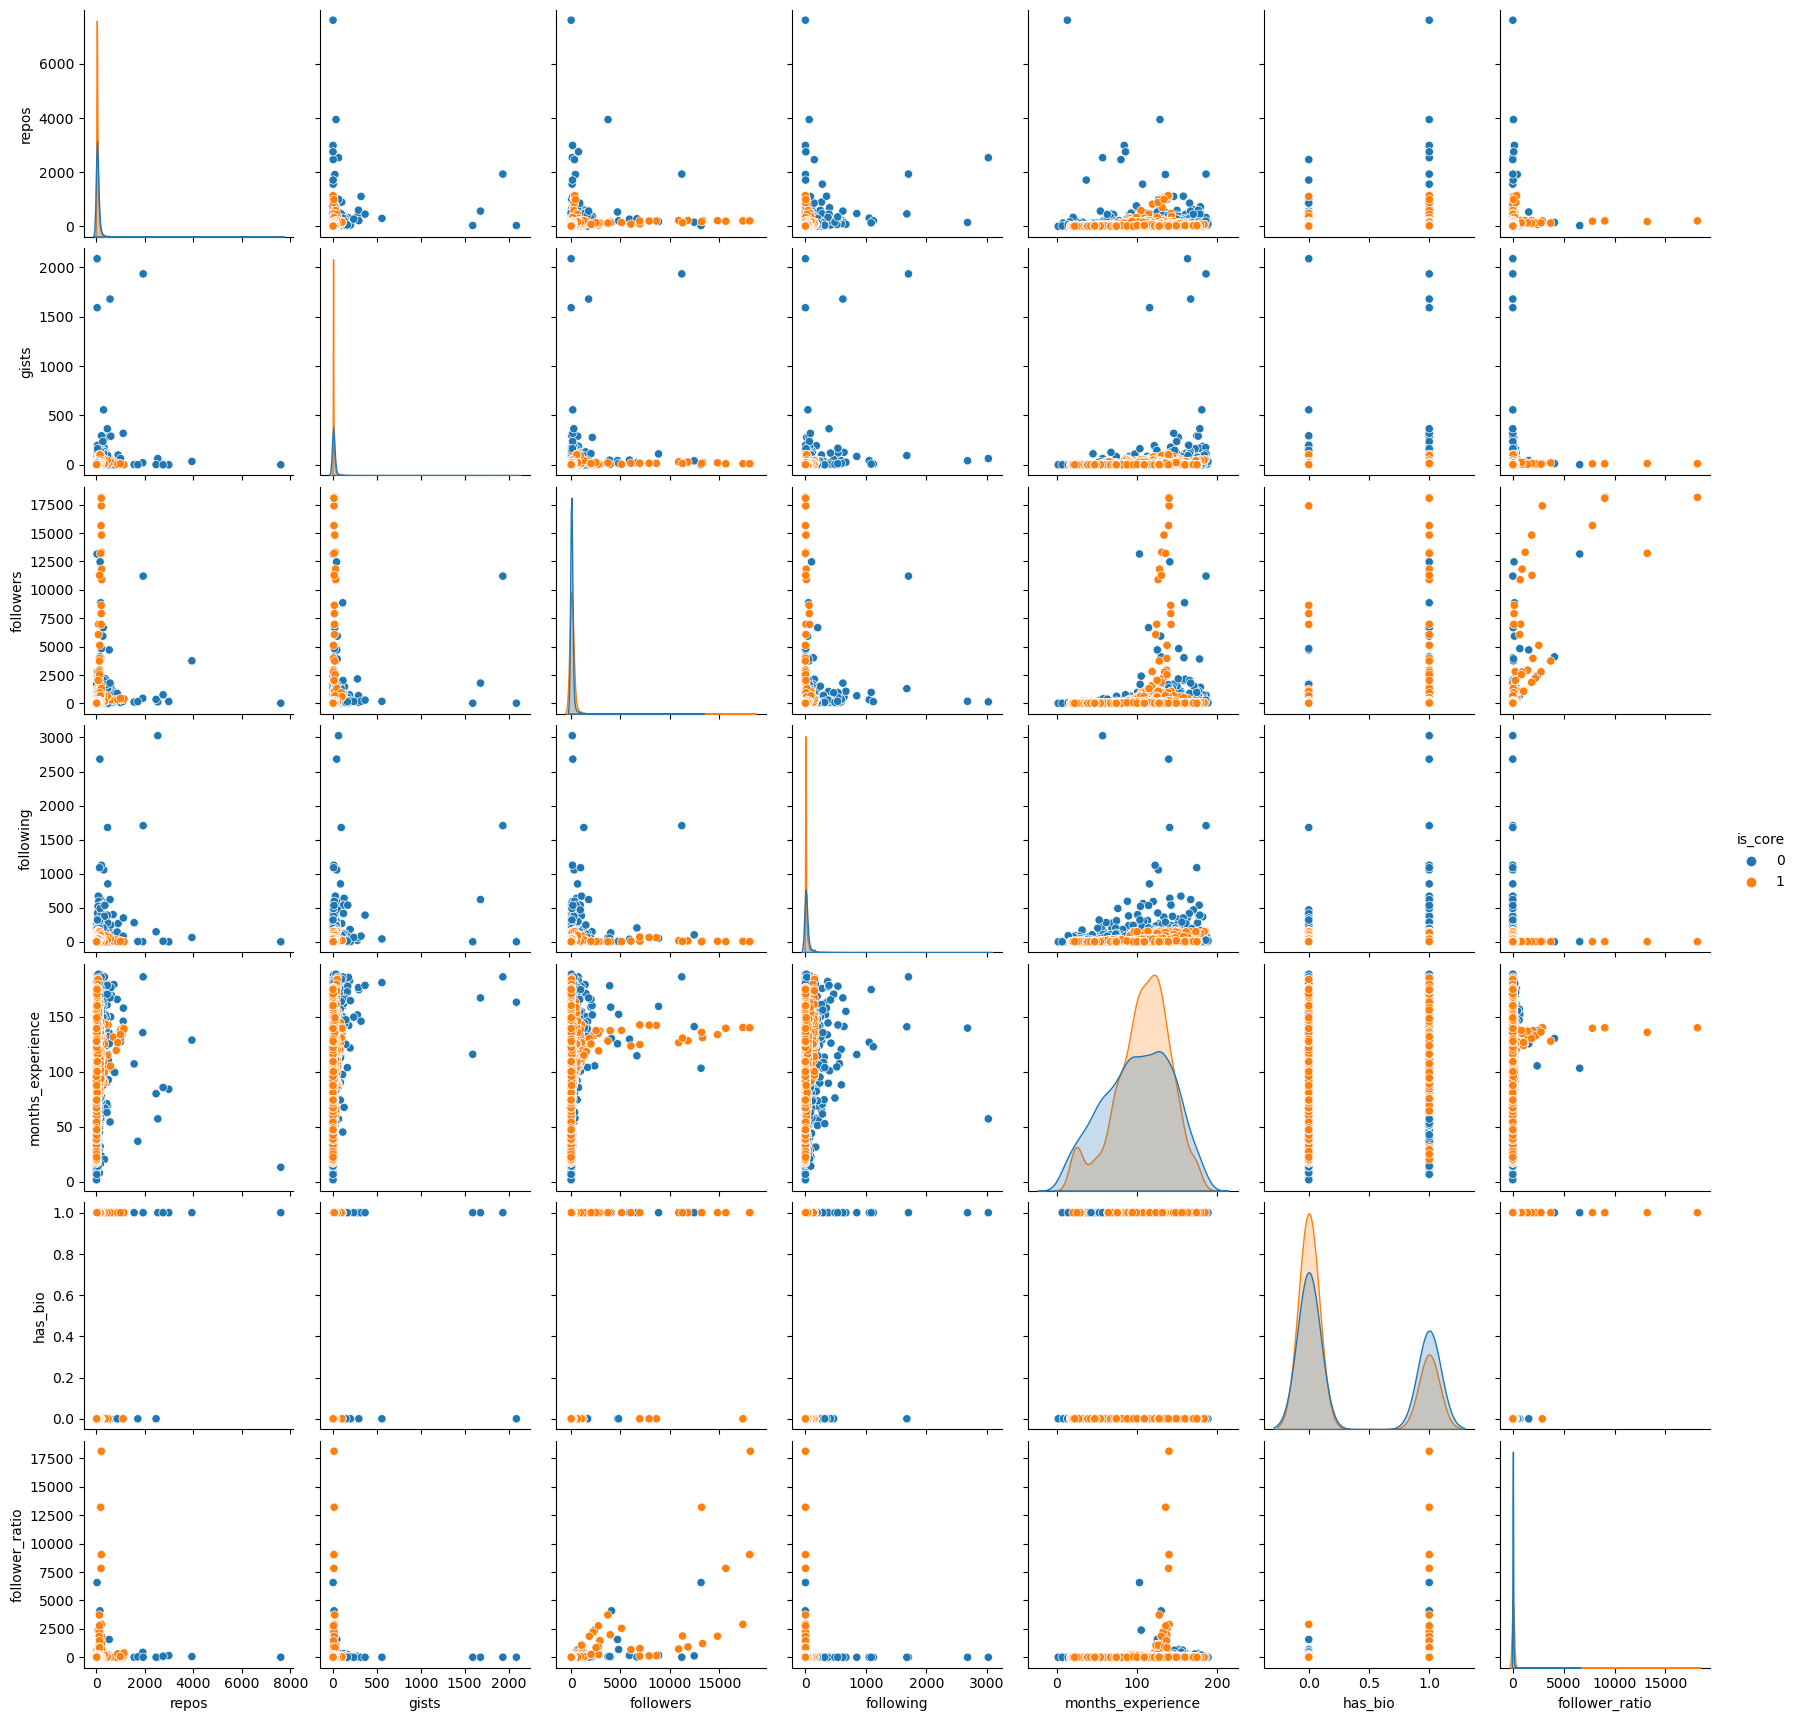

In [10]:
sns.pairplot(c1_train, hue = 'is_core')

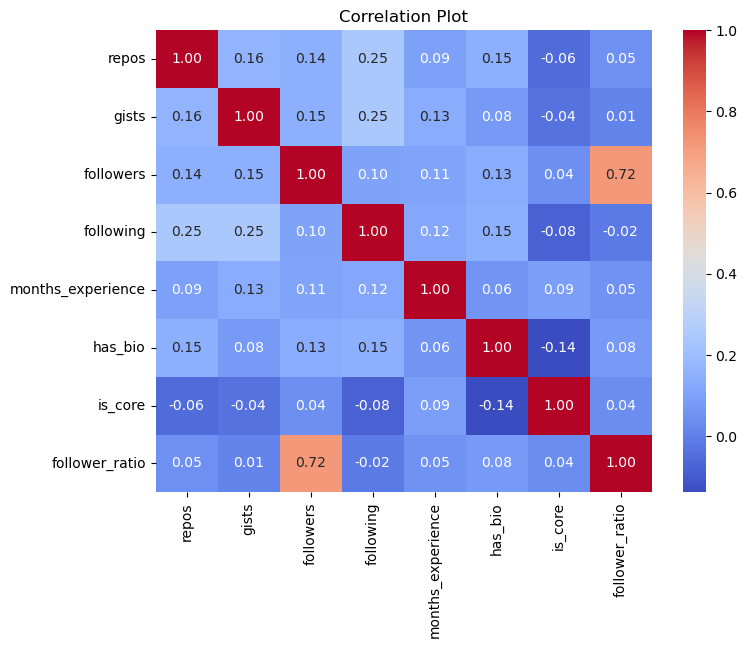

In [11]:
# Creating a correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(c1_train.corr(), annot=True, cmap='coolwarm', fmt=".2f")

# Adding a title
plt.title('Correlation Plot')

# Displaying the plot
plt.show() 

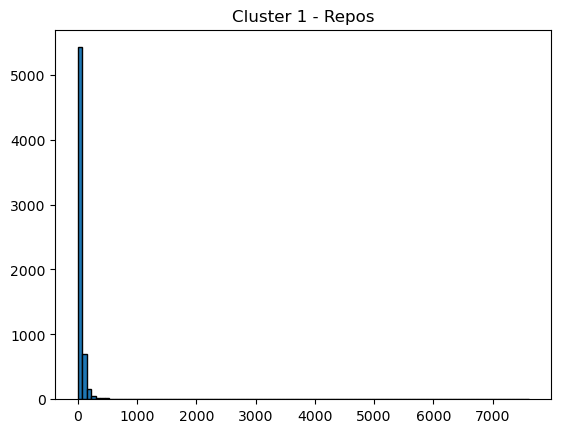

In [12]:
plt.hist(c1_train.repos, bins=100, edgecolor='black')
plt.title('Cluster 1 - Repos')
plt.show()

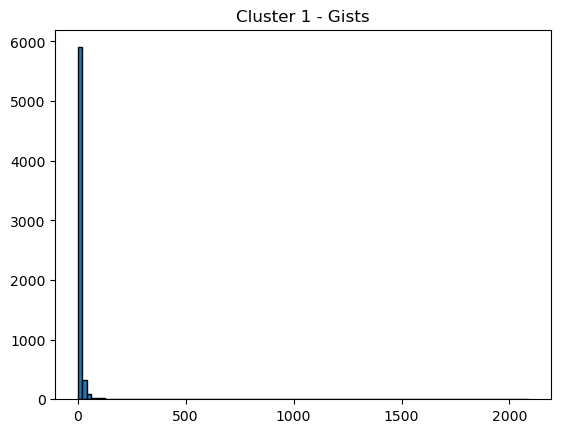

In [13]:
plt.hist(c1_train.gists, bins=100, edgecolor='black')
plt.title('Cluster 1 - Gists')
plt.show()

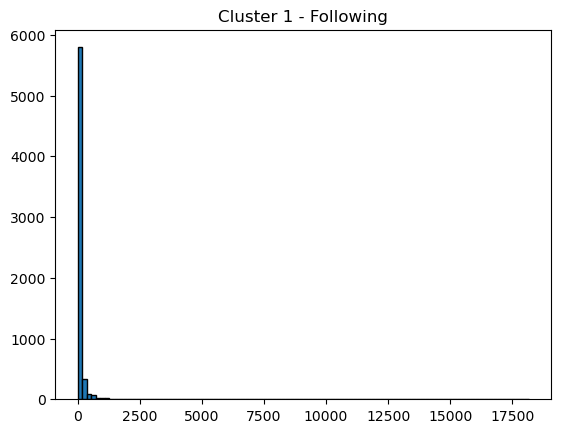

In [14]:
plt.hist(c1_train.followers, bins=100, edgecolor='black')
plt.title('Cluster 1 - Following')
plt.show()

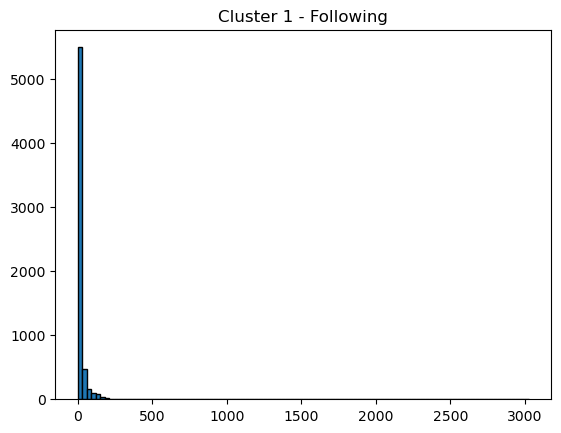

In [15]:
plt.hist(c1_train.following, bins=100, edgecolor='black')
plt.title('Cluster 1 - Following')
plt.show()

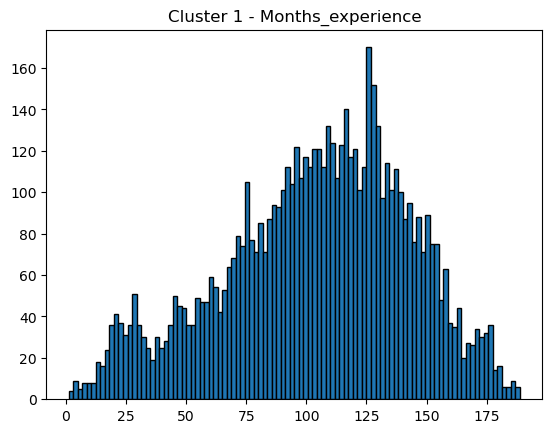

In [16]:
plt.hist(c1_train.months_experience, bins=100, edgecolor='black')
plt.title('Cluster 1 - Months_experience')
plt.show()

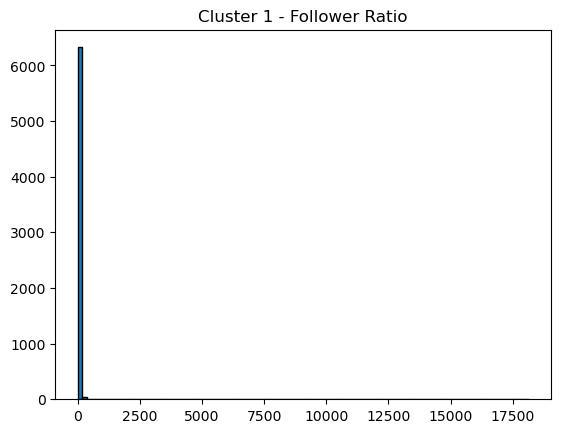

In [17]:
plt.hist(c1_train.follower_ratio, bins=100, edgecolor='black')
plt.title('Cluster 1 - Follower Ratio')
plt.show()

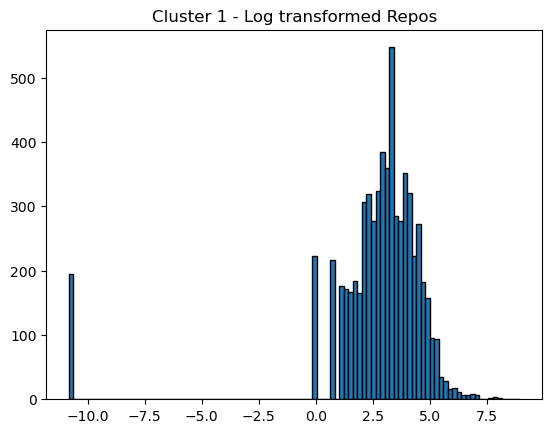

In [18]:
plt.hist(np.log(c1_train.repos+2e-5), bins=100, edgecolor='black')
plt.title('Cluster 1 - Log transformed Repos')
plt.show()

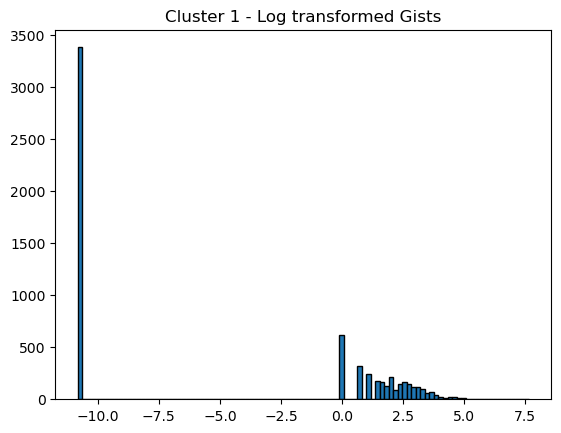

In [19]:
plt.hist(np.log(c1_train.gists+2e-5), bins=100, edgecolor='black')
plt.title('Cluster 1 - Log transformed Gists')
plt.show()

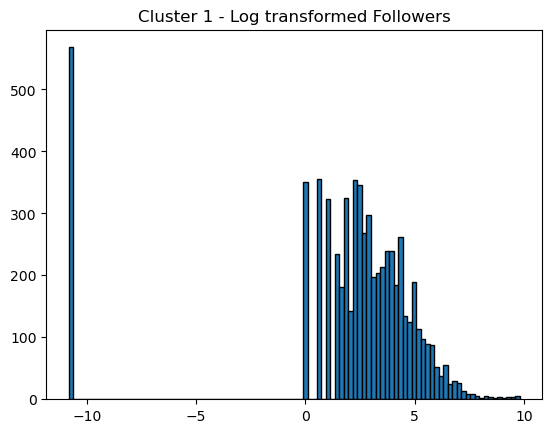

In [20]:
plt.hist(np.log(c1_train.followers+2e-5), bins=100, edgecolor='black')
plt.title('Cluster 1 - Log transformed Followers')
plt.show()

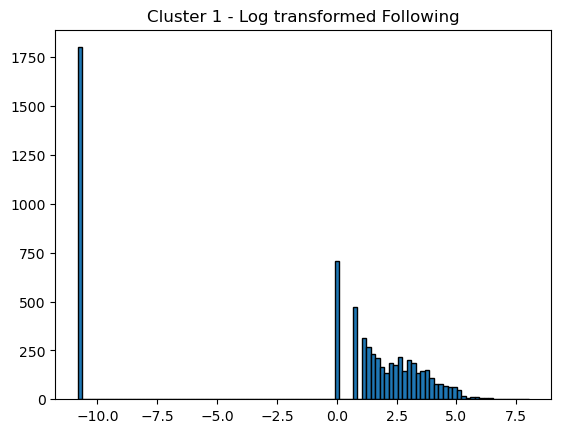

In [21]:
plt.hist(np.log(c1_train.following+2e-5), bins=100, edgecolor='black')
plt.title('Cluster 1 - Log transformed Following')
plt.show()

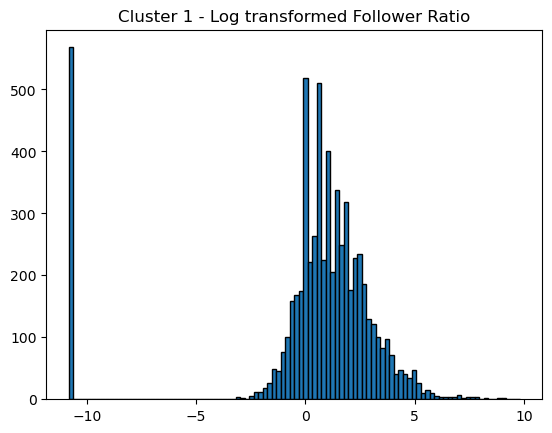

In [22]:
plt.hist(np.log(c1_train.follower_ratio + 2e-5), bins=100, edgecolor='black')
plt.title('Cluster 1 - Log transformed Follower Ratio')
plt.show()

In [23]:
c1_train_log = c1_train.copy()
c1_train_log['repos'] = np.log(c1_train_log.repos+2e-5)
c1_train_log['gists'] = np.log(c1_train_log.gists+2e-5)
c1_train_log['followers'] = np.log(c1_train_log.followers+2e-5)
c1_train_log['following'] = np.log(c1_train_log.following+2e-5)
c1_train_log['follower_ratio'] = np.log(c1_train_log.follower_ratio+2e-5)
c1_train_log

,repos,gists,followers,following,months_experience,has_bio,is_core,follower_ratio
0,3.761,-10.820,2.565,2.890,66.280,0,0,-0.325
1,2.708,-10.820,1.609,1.099,76.610,1,0,0.511
2,-10.820,-10.820,-10.820,-10.820,45.560,0,0,-10.820
3,4.394,-10.820,2.303,2.996,111.900,1,0,-0.693
4,-10.820,-10.820,-10.820,-10.820,42.180,0,0,-10.820
...,...,...,...,...,...,...,...,...
6414,2.708,0.000,1.946,-10.820,128.480,0,1,1.946
6415,1.099,0.000,2.398,0.000,126.604,0,1,2.398
6416,2.303,0.000,2.398,0.000,128.450,0,1,2.398
6417,2.773,0.000,2.398,0.000,129.733,0,1,2.398


In [24]:
test_df['follower_ratio'] = np.where(test_df['following'] == 0, test_df['followers'], test_df['followers'] / test_df['following'])
test_df

,repos,gists,followers,following,months_experience,has_bio,is_core,follower_ratio
8113,35,1,0,0,56.160,0,0,0.000
211,165,155,161,48,88.790,1,0,3.354
5151,0,0,0,0,7.670,0,0,0.000
4191,10,0,22,4,139.260,0,1,5.500
7588,2,0,0,0,52.080,0,0,0.000
...,...,...,...,...,...,...,...,...
7802,27,0,14,0,159.950,1,1,14.000
5182,132,35,758,38,153.640,1,0,19.947
7793,9,0,1,0,101.060,1,0,1.000
6663,3,0,0,1,21.090,0,0,0.000


In [25]:
test_df['repos'] = np.log(test_df.repos+2e-5)
test_df['gists'] = np.log(test_df.gists+2e-5)
test_df['followers'] = np.log(test_df.followers+2e-5)
test_df['following'] = np.log(test_df.following+2e-5)
test_df['follower_ratio'] = np.log(test_df.follower_ratio+2e-5)
test_df

,repos,gists,followers,following,months_experience,has_bio,is_core,follower_ratio
8113,3.555,0.000,-10.820,-10.820,56.160,0,0,-10.820
211,5.106,5.043,5.081,3.871,88.790,1,0,1.210
5151,-10.820,-10.820,-10.820,-10.820,7.670,0,0,-10.820
4191,2.303,-10.820,3.091,1.386,139.260,0,1,1.705
7588,0.693,-10.820,-10.820,-10.820,52.080,0,0,-10.820
...,...,...,...,...,...,...,...,...
7802,3.296,-10.820,2.639,-10.820,159.950,1,1,2.639
5182,4.883,3.555,6.631,3.638,153.640,1,0,2.993
7793,2.197,-10.820,0.000,-10.820,101.060,1,0,0.000
6663,1.099,-10.820,-10.820,0.000,21.090,0,0,-10.820


In [26]:
scaler = StandardScaler()
X_std = c1_train_log.drop(columns=['has_bio', 'is_core'])
x2 = c1_train_log[['has_bio', 'is_core']]
X_std = scaler.fit_transform(X_std)
train = pd.DataFrame(X_std, columns=['repos', 'gists', 'followers', 'following', 'months_experience', 'follower_ratio'])
train = pd.concat([train, x2], axis = 1)
train

,repos,gists,followers,following,months_experience,follower_ratio,has_bio,is_core
0,0.422,-0.939,0.190,0.746,-0.972,-0.156,0,0
1,0.033,-0.939,-0.034,0.443,-0.705,0.067,1,0
2,-4.959,-0.939,-2.957,-1.566,-1.508,-2.946,0,0
3,0.656,-0.939,0.129,0.763,0.207,-0.253,1,0
4,-4.959,-0.939,-2.957,-1.566,-1.595,-2.946,0,0
...,...,...,...,...,...,...,...,...
6414,0.033,0.770,0.045,-1.566,0.636,0.448,0,1
6415,-0.560,0.770,0.151,0.258,0.587,0.569,0,1
6416,-0.116,0.770,0.151,0.258,0.635,0.569,0,1
6417,0.057,0.770,0.151,0.258,0.668,0.569,0,1


In [27]:
X_std = test_df.drop(columns=['has_bio', 'is_core'])
x2 = test_df[['has_bio', 'is_core']]
X_std = scaler.transform(X_std)
test = pd.DataFrame(X_std, columns=['repos', 'gists', 'followers', 'following', 'months_experience', 'follower_ratio'])
test = test.reset_index(drop=True)
x2 = x2.reset_index(drop=True)
test = pd.concat([test, x2], axis = 1)
test

,repos,gists,followers,following,months_experience,follower_ratio,has_bio,is_core
0,0.346,0.770,-2.957,-1.566,-1.234,-2.946,0,0
1,0.918,1.566,0.782,0.911,-0.390,0.253,1,0
2,-4.959,-0.939,-2.957,-1.566,-2.487,-2.946,0,0
3,-0.116,-0.939,0.314,0.492,0.915,0.384,0,1
4,-0.710,-0.939,-2.957,-1.566,-1.339,-2.946,0,0
...,...,...,...,...,...,...,...,...
836,0.250,-0.939,0.208,-1.566,1.449,0.633,1,1
837,0.836,1.331,1.146,0.871,1.286,0.727,1,0
838,-0.155,-0.939,-0.413,-1.566,-0.073,-0.069,1,0
839,-0.560,-0.939,-2.957,0.258,-2.140,-2.946,0,0


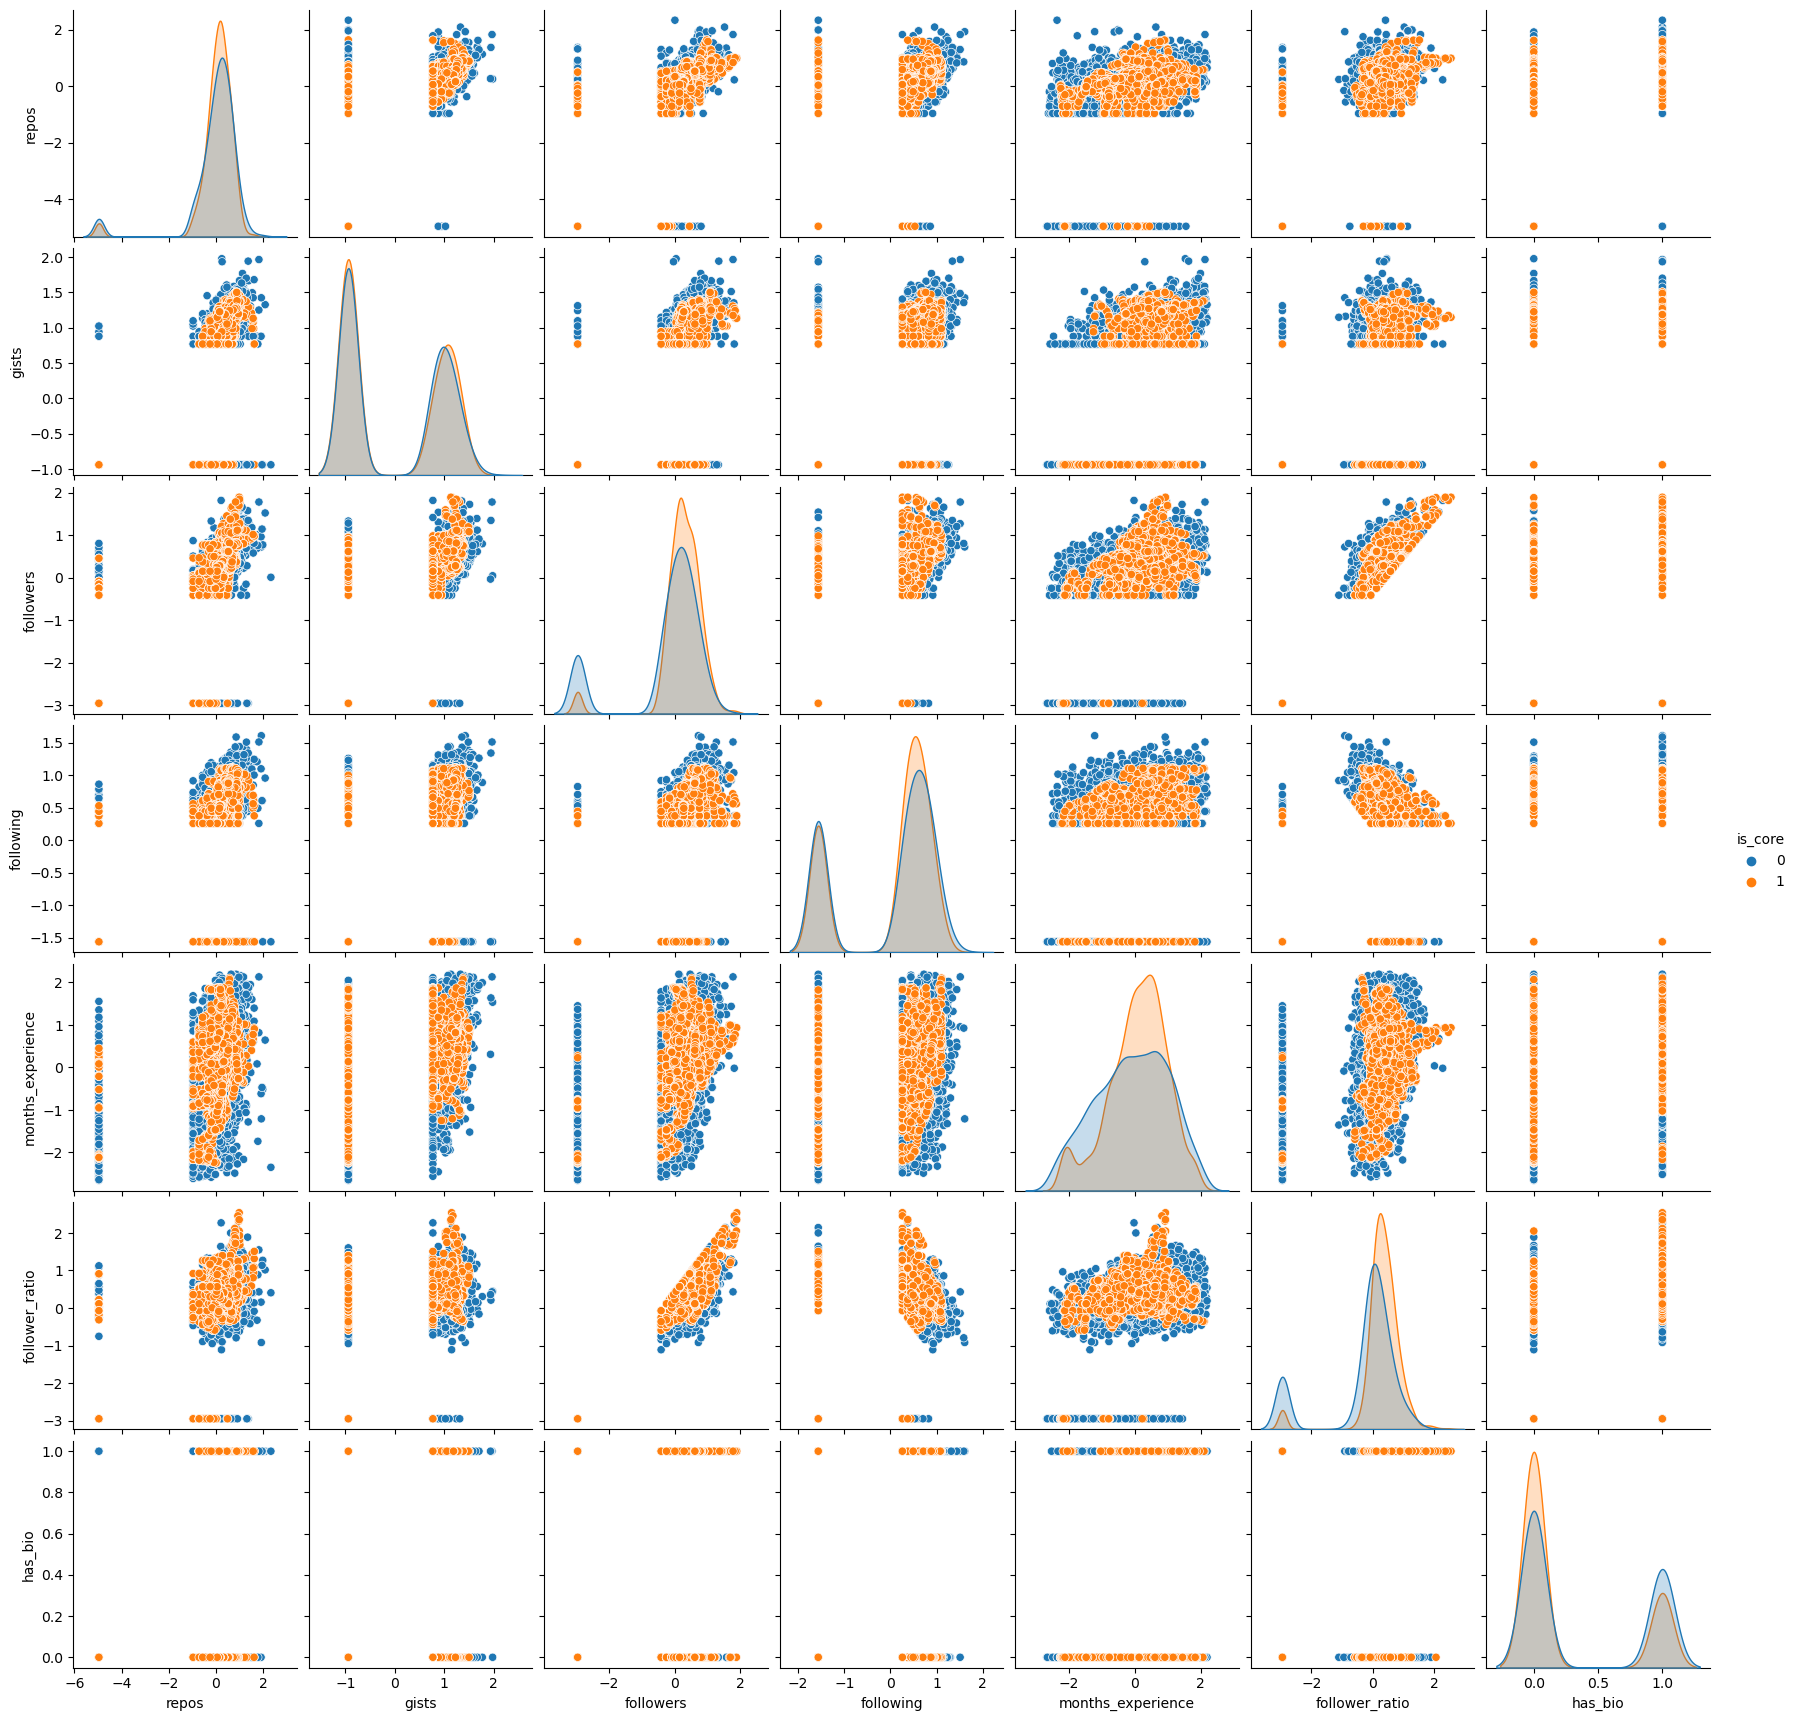

In [28]:
sns.pairplot(train, hue = 'is_core')

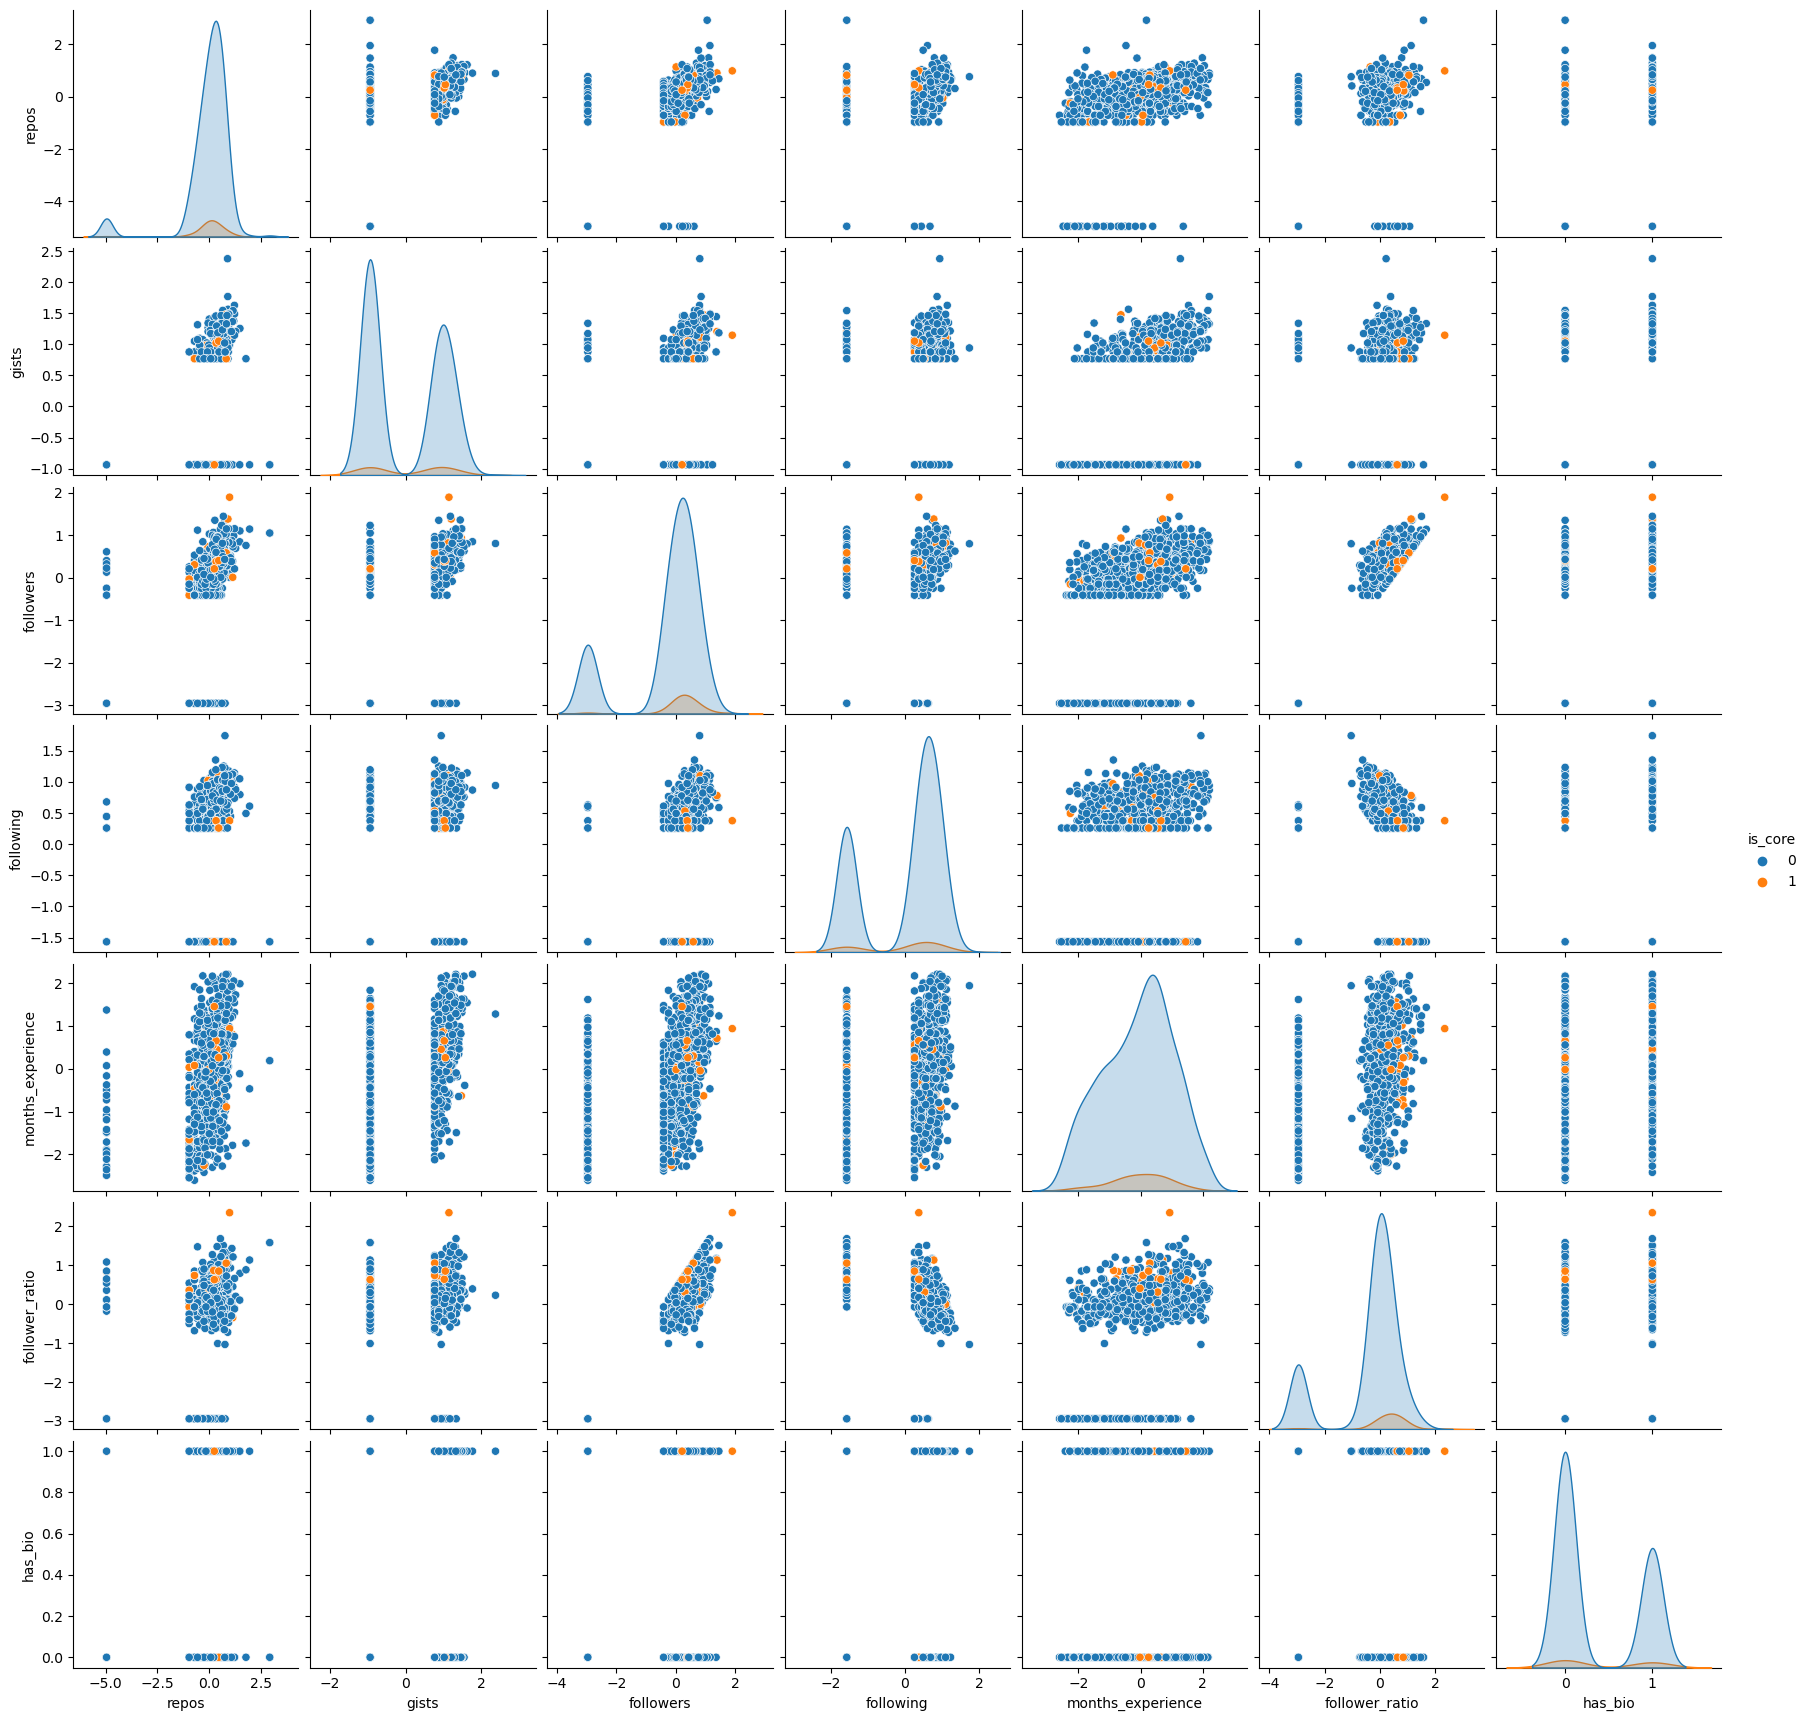

In [29]:
sns.pairplot(test, hue = 'is_core')

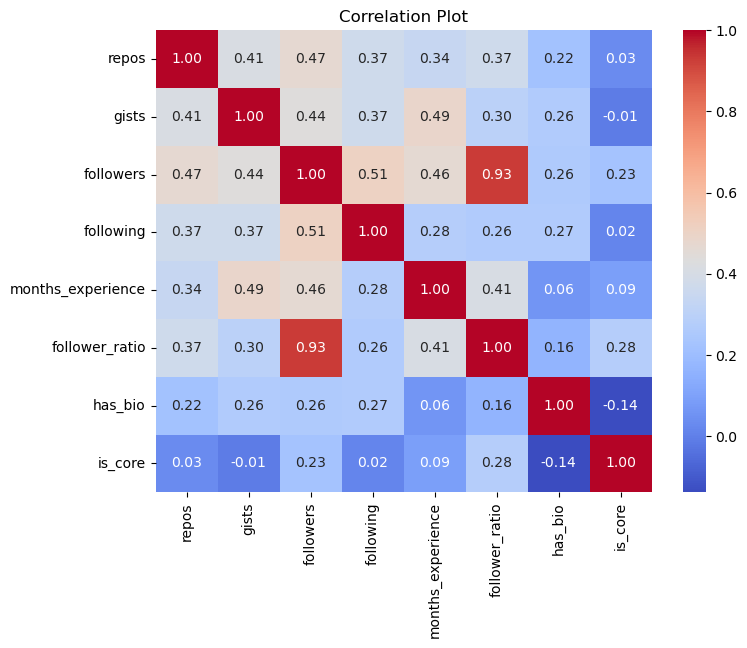

In [30]:
# Creating a correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm', fmt=".2f")

# Adding a title
plt.title('Correlation Plot')

# Displaying the plot
plt.show() 

In [31]:
X = train.drop('is_core', axis=1)
y = train['is_core']

# Calculating mutual information for each feature
mi_scores = mutual_info_classif(X, y)  # For classification tasks


# Displaying the mutual information scores
for feature, score in zip(X.columns, mi_scores):
    print(f"{feature}: {score:.4f}")

repos: 0.0146
gists: 0.0167
followers: 0.0424
following: 0.0129
months_experience: 0.0612
follower_ratio: 0.0840
has_bio: 0.0140


In [32]:
train['has_bio'] = pd.Categorical(train['has_bio'])
train['has_bio'] = pd.Categorical(train['has_bio'])

test['is_core'] = pd.Categorical(test['is_core'])
test['is_core'] = pd.Categorical(test['is_core'])

X_train = train.drop(columns = "is_core")
X_test = test.drop(columns = 'is_core')

y_train = train['is_core']
y_test = test['is_core']

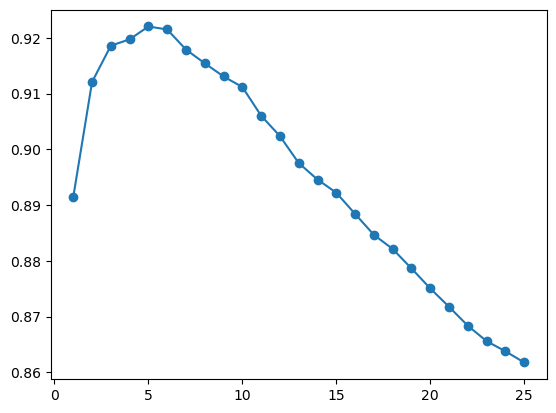

In [33]:
# Create a KNN classifier
k_vals = list(range(1, 26))
scores = []

for k in k_vals:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)  # You can adjust the number of neighbors (n_neighbors) as needed

    # Perform 10-fold cross-validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(knn_classifier, X_train, y_train, cv=kf, scoring = 'roc_auc')
    scores.append(np.mean(cv_scores))
    
plt.plot(k_vals, scores, marker='o', linestyle='-')
plt.show()


In [34]:
max_k = scores.index(max(scores))+1
knn_classifier = KNeighborsClassifier(n_neighbors=max_k)
knn_classifier.fit(X_train, y_train)


y_pred = knn_classifier.predict(X_test)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Set Accuracy: {accuracy:.2f}")

# Print a classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[569 219]
 [ 25  28]]

Test Set Accuracy: 0.71

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.72      0.82       788
           1       0.11      0.53      0.19        53

    accuracy                           0.71       841
   macro avg       0.54      0.63      0.51       841
weighted avg       0.90      0.71      0.78       841



In [35]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_samples': [0.5, 0.6, 0.7]
}


# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV with 10-fold cross-validation
rf_grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=10, scoring='roc_auc', verbose = 1, n_jobs = -1)

t1 = time.time()
# Fit the grid search to the data
rf_grid_search.fit(X_train, y_train)

print("Search completed in", str(round((time.time() - t1) / 60, 2)), "Minutes\n")

# Print the best hyperparameters
print("Best Hyperparameters:", rf_grid_search.best_params_)

# Print the best cross-validation score
print("Best Cross-Validation Accuracy: {:.2f}".format(rf_grid_search.best_score_))

# Evaluate the model on the test set with the best parameters
rf_best_model = rf_grid_search.best_estimator_
y_pred = rf_best_model.predict(X_test)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Set Accuracy: {accuracy:.2f}")

# Print a classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Fitting 10 folds for each of 243 candidates, totalling 2430 fits
Search completed in 0.88 Minutes

Best Hyperparameters: {'max_depth': 10, 'max_samples': 0.7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best Cross-Validation Accuracy: 0.88
Confusion Matrix:
[[587 201]
 [ 24  29]]

Test Set Accuracy: 0.73

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.74      0.84       788
           1       0.13      0.55      0.20        53

    accuracy                           0.73       841
   macro avg       0.54      0.65      0.52       841
weighted avg       0.91      0.73      0.80       841



In [36]:
param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [3, 5, 10, 25],
    'min_samples_leaf': [2, 3, 5, 10]
}

# Initialize the DT Classifier
clf = tree.DecisionTreeClassifier(random_state=42, criterion = 'entropy')

# Initialize GridSearchCV with 10-fold cross-validation
dt_grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=10, scoring='roc_auc', verbose = 1, n_jobs = -1)

t1 = time.time()
# Fit the grid search to the data
dt_grid_search.fit(X_train, y_train)

print("Search completed in", str(round((time.time() - t1) / 60, 2)), "Minutes\n")

# Print the best hyperparameters
print("Best Hyperparameters:", dt_grid_search.best_params_)

# Print the best cross-validation score
print("Best Cross-Validation Accuracy: {:.2f}".format(dt_grid_search.best_score_))

# Evaluate the model on the test set with the best parameters
dt_best_model = dt_grid_search.best_estimator_
y_pred = dt_best_model.predict(X_test)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print accuracy, precision, recall, and F1 score|
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Set Accuracy: {accuracy:.2f}")

# Print a classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Fitting 10 folds for each of 48 candidates, totalling 480 fits
Search completed in 0.01 Minutes

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 3}
Best Cross-Validation Accuracy: 0.80
Confusion Matrix:
[[560 228]
 [ 23  30]]

Test Set Accuracy: 0.70

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.71      0.82       788
           1       0.12      0.57      0.19        53

    accuracy                           0.70       841
   macro avg       0.54      0.64      0.50       841
weighted avg       0.91      0.70      0.78       841



In [37]:
y_pred = dt_best_model.predict(X_train)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_train, y_pred)
print(f"\nTest Set Accuracy: {accuracy:.2f}")

# Print a classification report
print('\nClassification Report:')
print(classification_report(y_train, y_pred))

Confusion Matrix:
[[2483  699]
 [ 422 2815]]

Test Set Accuracy: 0.83

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.78      0.82      3182
           1       0.80      0.87      0.83      3237

    accuracy                           0.83      6419
   macro avg       0.83      0.82      0.82      6419
weighted avg       0.83      0.83      0.82      6419



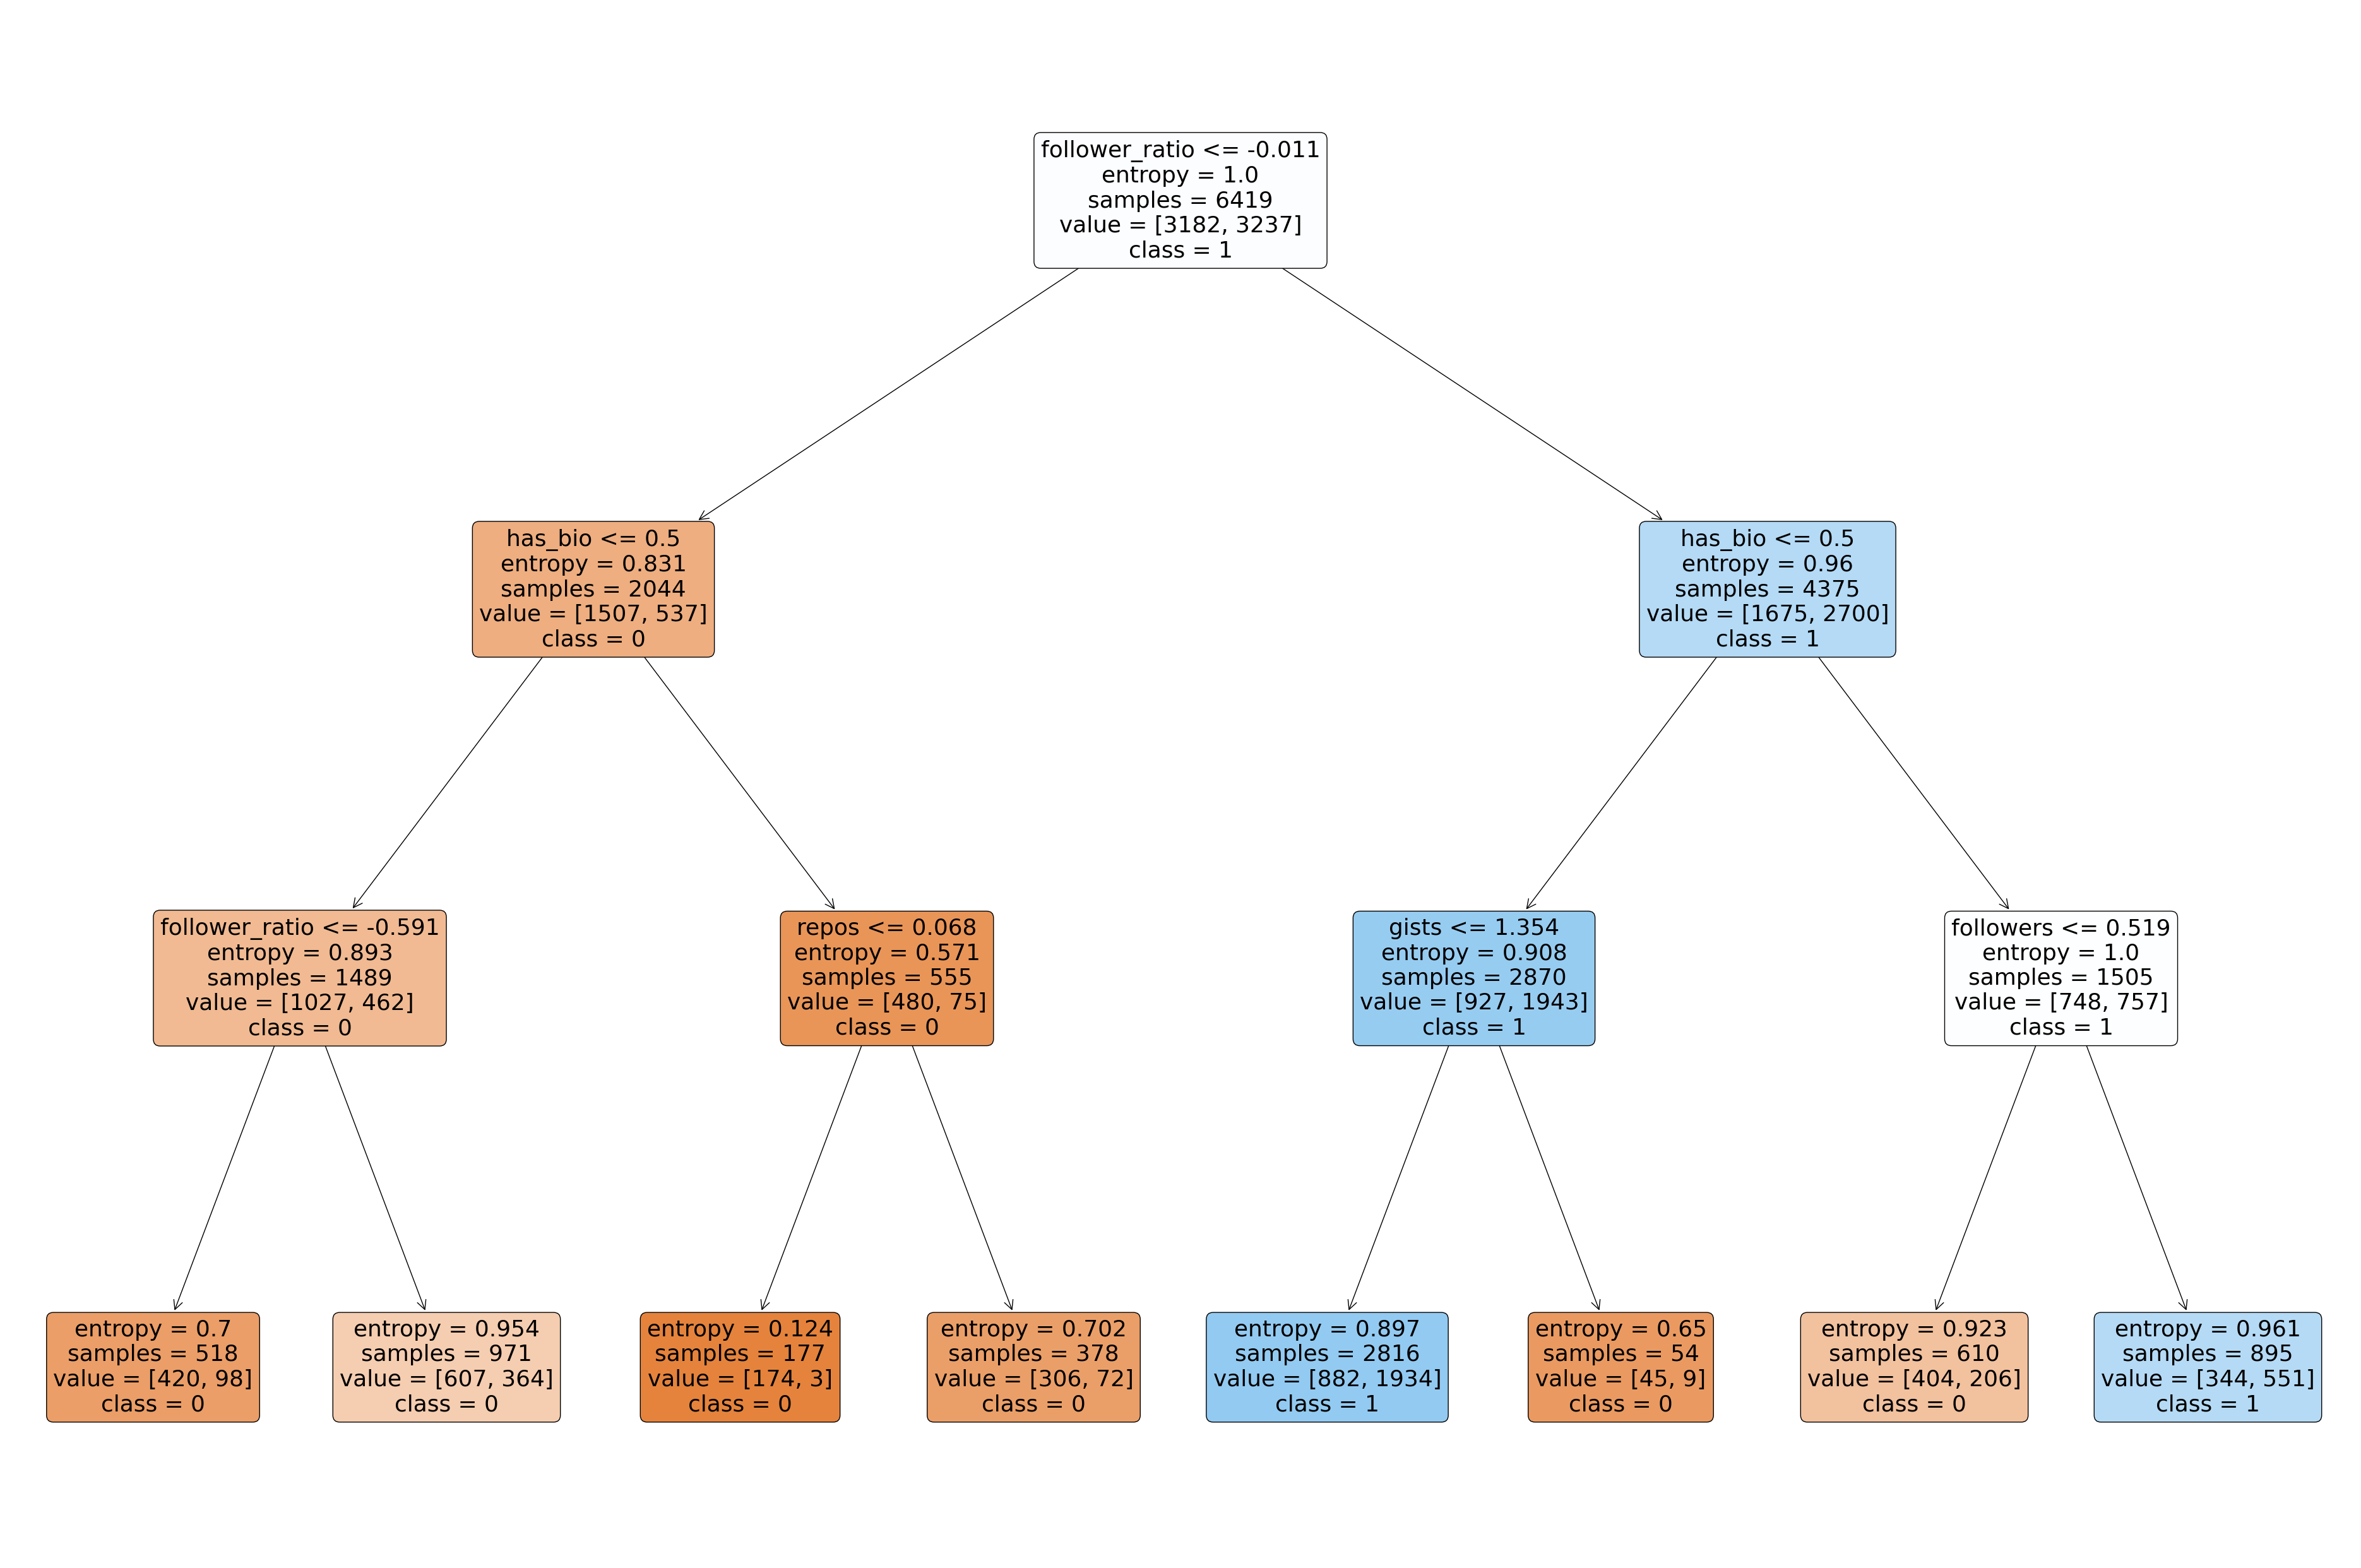

In [38]:
clf = tree.DecisionTreeClassifier(max_depth = 3, criterion='entropy')
clf = clf.fit(X_train, y_train)
plt.figure(figsize=(48, 32))
tree.plot_tree(clf, filled = True, rounded = True, feature_names = X_train.columns, class_names = y_train.unique().astype(str).tolist())
plt.show()

In [39]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}


# Initialize the Random Forest Classifier
xgboost = GradientBoostingClassifier(random_state=42)

# Initialize GridSearchCV with 10-fold cross-validation
xg_grid_search = GridSearchCV(estimator=xgboost, param_grid=param_grid, cv=10, scoring='roc_auc', verbose = 1, n_jobs = -1)

t1 = time.time()
# Fit the grid search to the data
xg_grid_search.fit(X_train, y_train)

print("Search completed in", str(round((time.time() - t1) / 60, 2)), "Minutes\n")

# Print the best hyperparameters
print("Best Hyperparameters:", xg_grid_search.best_params_)

# Print the best cross-validation score
print("Best Cross-Validation Accuracy: {:.2f}".format(xg_grid_search.best_score_))

# Evaluate the model on the test set with the best parameters
xg_best_model = xg_grid_search.best_estimator_
y_pred = xg_best_model.predict(X_test)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Set Accuracy: {accuracy:.2f}")

# Print a classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Fitting 10 folds for each of 243 candidates, totalling 2430 fits
Search completed in 3.47 Minutes

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150}
Best Cross-Validation Accuracy: 0.94
Confusion Matrix:
[[685 103]
 [ 36  17]]

Test Set Accuracy: 0.83

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.87      0.91       788
           1       0.14      0.32      0.20        53

    accuracy                           0.83       841
   macro avg       0.55      0.60      0.55       841
weighted avg       0.90      0.83      0.86       841



In [40]:
# Define the logistic regression model
logistic_regression = LogisticRegression(solver = 'saga', random_state = 42)

# Define the hyperparameter grid to search through
param_grid = {
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],  # Regularization type
    'C': [0.001, 0.01, 0.1, 1, 10],                  # Inverse of regularization strength              # Algorithm to use in the optimization problem
    'l1_ratio': [0.1, 0.5, 0.9],                    # Elastic Net mixing parameter (used when penalty='elasticnet')
}

# Initialize GridSearchCV
log_grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv=10, scoring='roc_auc', verbose = 1, n_jobs = -1)
t1 = time.time()
# Fit the grid search to the data
log_grid_search.fit(X_train, y_train)

print("Search completed in", str(round((time.time() - t1) / 60, 2)), "Minutes\n")

Fitting 10 folds for each of 60 candidates, totalling 600 fits
Search completed in 0.01 Minutes



In [41]:
# Print the best hyperparameters
print("Best Hyperparameters:", log_grid_search.best_params_)

# Print the best cross-validation score
print("Best Cross-Validation Accuracy: {:.2f}".format(log_grid_search.best_score_))

# Evaluate the model on the test set with the best parameters
log_best_model = log_grid_search.best_estimator_
y_pred = log_best_model.predict(X_test)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Set Accuracy: {accuracy:.2f}")

# Print a classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Best Hyperparameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'elasticnet'}
Best Cross-Validation Accuracy: 0.71
Confusion Matrix:
[[354 434]
 [  9  44]]

Test Set Accuracy: 0.47

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.45      0.62       788
           1       0.09      0.83      0.17        53

    accuracy                           0.47       841
   macro avg       0.53      0.64      0.39       841
weighted avg       0.92      0.47      0.59       841

